In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None
config_path = "data_config.json"
import json
with open(config_path, "r") as config_file:
    config = json.load(config_file)
data_path = config["data_path"]
features_path = config["features_path"]
img_directory_training = config["img_directory_training"]
img_directory_test = config["img_directory_test"]

from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# processor = BlipProcessor.from_pretrained("/home/geek/Workspace/BCI/Code/Decoding/BLIP/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("/home/geek/Workspace/BCI/Code/Decoding/BLIP/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")
def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []
    blip_texts = []
    if train:
        text_directory = img_directory_training
    else:
        text_directory = img_directory_test
    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()
    
    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:
        try:
            idx = dir.index('_')
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue
            
        new_description = f"{description}"
        texts.append(new_description)

    if train:
        img_directory = img_directory_training
    else:
        img_directory =img_directory_test
    
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]

    if classes is not None and pictures is not None:
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))                                                        

    elif classes is not None and pictures is None:
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
                
    elif classes is None:
        for idx, folder in enumerate(all_folders):
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()  
            images.extend(os.path.join(folder_path, img) for img in all_images)
            raw_image = Image.open(os.path.join(folder_path, all_images[0])).convert("RGB")
            # print(raw_image)
            # conditional image captioning
            text = [i.join(" ") for i in texts[idx].split("_")]
            # inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

            # out = model.generate(**inputs)
            # blip_text = processor.decode(out[0], skip_special_tokens=True)
            # print(blip_text)
            # blip_texts.append(blip_text)
    else:
        print("Error")
    return texts, blip_texts, images
texts, blip_texts, images = load_data()
# texts[3]
# images.shape
# blip_texts

In [1]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader


os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from torch import Tensor
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model + 1, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[:d_model // 2 + 1])
        pe[:, 1::2] = torch.cos(position * div_term[:d_model // 2])

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(0), :].unsqueeze(1).repeat(1, x.size(1), 1)
        x = x + pe
        return x




class EEGAttention(nn.Module):
    def __init__(self, channel, d_model, nhead):
        super(EEGAttention, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.channel = channel
        self.d_model = d_model

    def forward(self, src):
        src = src.permute(2, 0, 1)  # Change shape to [time_length, batch_size, channel]
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output.permute(1, 2, 0)  # Change shape back to [batch_size, channel, time_length]

class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # revised from shallownet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=1024, proj_dim=1024, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return x 

class ATM_S(nn.Module):    
    def __init__(self, num_channels=63, sequence_length=250, num_subjects=1, num_features=64, num_latents=1024, num_blocks=1):
        super(ATM_S, self).__init__()
        self.attention_model = EEGAttention(num_channels, num_channels, nhead=1)   
        self.subject_wise_linear = nn.ModuleList([nn.Linear(sequence_length, sequence_length) for _ in range(num_subjects)])
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()       
         
    def forward(self, x):
        x = self.attention_model(x)
        # print(f'After attention shape: {x.shape}')
         
        x = self.subject_wise_linear[0](x)
        # print(f'After subject-specific linear transformation shape: {x.shape}')
        eeg_embedding = self.enc_eeg(x)
        
        out = self.proj_eeg(eeg_embedding)
        return out  
    
    

def get_eegfeatures(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0
    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            # print("eeg_data", eeg_data.shape)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = eegmodel(eeg_data).float()
            features_list.append(eeg_features)
            logit_scale = eegmodel.logit_scale 
                   
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):
                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]
                
                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                # logits_single = (logits_text + logits_img) / 2.0
                logits_single = logits_img
                # print("logits_single", logits_single.shape)
                # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1        
                total += 1
        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"ATM_S_eeg_features_{sub}_test.pt")  # Save features as .pt file
            
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels


config = {
"data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 1,
"logger": True
}

subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04',  'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']    
data_path = config['data_path']
test_dataset = EEGDataset(data_path, subjects= subjects, train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)



text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features


eeg_model = ATM_S()
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# text_features_test_all.to(device)
# img_features_test_all.to(device)
eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/BrainAligning_retrieval/models/contrast/sub-08/01-30_00-44/40.pth"))

# model.load_state_dict(torch.load("/home/ldy/Workspace/Reconstruction/models/sub-01_30.pth"))
eeg_model.to(device)
# sub = 'sub-08'
for sub in subjects:     
    test_loss, test_accuracy,labels = get_eegfeatures(sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all,k=200)
    print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
number of parameters: 3246741
features_tensor torch.Size([200, 1024])
 - Test Loss: 0.6082, Test Accuracy: 0.3600


: 

In [3]:
def get_eegfeatures(sub, eegmodel, dataloader, device, img_features_all, k):
    eegmodel.eval()
    img_features_all = img_features_all.to(device).float()
    features_list = []
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            labels = labels.to(device)
            eeg_features = eegmodel(eeg_data).float()
            features_list.append(eeg_features)

            # Top-1 and Top-5 retrieval
            for idx, label in enumerate(labels):
                similarities = F.cosine_similarity(eeg_features[idx].unsqueeze(0), img_features_all)
                _, top5_indices = torch.topk(similarities, 5)
                top1_correct += label.item() in top5_indices[:1]
                top5_correct += label.item() in top5_indices

                total += 1

    top1_acc = top1_correct / total
    top5_acc = top5_correct / total
    return top1_acc, top5_acc

top1_accuracy, top5_accuracy = get_eegfeatures(sub, eeg_model, test_loader, device, img_features_test_all, k=200)
print(f"Top-1 Retrieval Accuracy: {top1_accuracy:.4f}")
print(f"Top-5 Retrieval Accuracy: {top5_accuracy:.4f}")

Top-1 Retrieval Accuracy: 0.3600
Top-5 Retrieval Accuracy: 0.7250


In [4]:
# emb_img_test = torch.load('ViT-H-14_features_test.pt')
# emb_img_train = torch.load('ViT-H-14_features_train.pt')
# emb_eeg = torch.load('./ATM_S_eeg_features_sub-08.pt')
emb_eeg_test = torch.load('./ATM_S_eeg_features_sub-08_test.pt')
# emb_img_test.shape

In [5]:
# load image embeddings
data = torch.load('ViT-H-14_features_test.pt')
emb_img_test = data['img_features']

# load image embeddings
data = torch.load('ViT-H-14_features_test.pt')
emb_img_train = data['img_features']

topk_indices tensor([174,   0, 153,  59,  16])


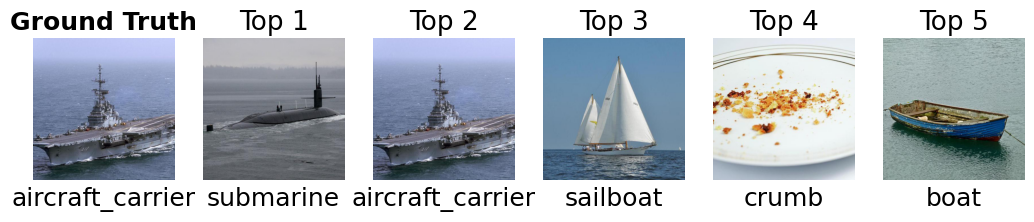

In [45]:
def display_top_images(eeg_feature, image_features, images, texts, ground_truth_idx, top_k=5):
    similarities = F.cosine_similarity(eeg_feature.unsqueeze(0), image_features)
    topk_indices = torch.topk(similarities, top_k).indices
    print("topk_indices", topk_indices)
    plt.figure(figsize=(15, 3))
    
    gt_image = Image.open(images[ground_truth_idx])
    plt.imshow(gt_image)
    plt.axis('off')
    plt.title("Ground Truth", fontweight='bold', fontsize=18)
    # show texts[ground_truth_idx] under the images
    plt.text(0.5, -0.05, texts[ground_truth_idx], ha='center', va='top', transform=plt.gca().transAxes, fontsize=18)

        image = Image.open(images[idx])
        plt.subplot(1, top_k + 2, i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Top {i-1}", fontsize=19)
        # show texts[idx] under the images
        plt.text(0.5, -0.05, texts[idx], ha='center', va='top', transform=plt.gca().transAxes, fontsize=18)

display_top_images(emb_eeg_test[eeg_feature_idx], emb_img_test, images, texts, ground_truth_idx)

# RSA

In [ ]:
# animal, food, vehicle, tool, and others

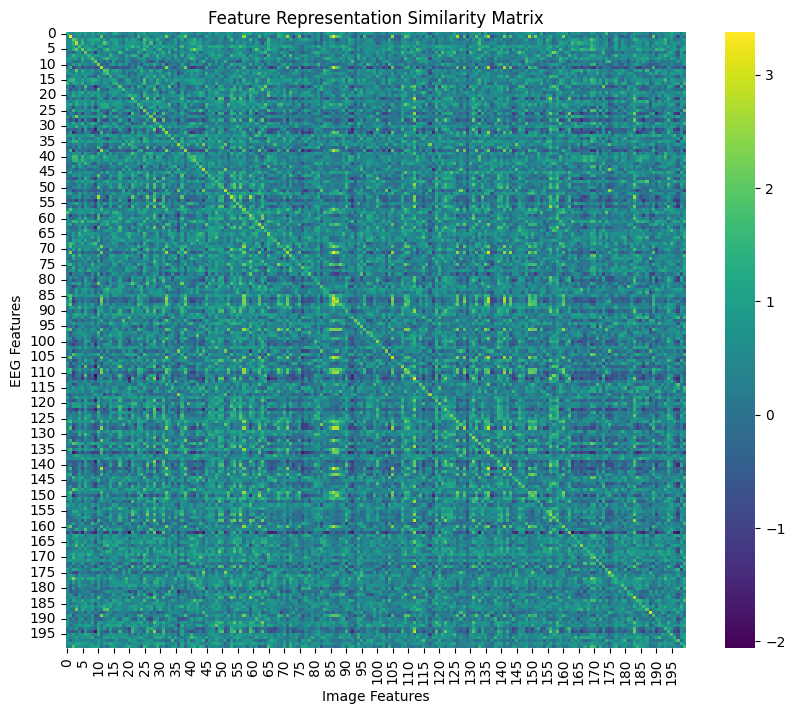

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

eeg_features_np = emb_eeg_test.detach().cpu().numpy()
img_features_np = emb_img_test.detach().cpu().numpy()

similarity_matrix = np.matmul(eeg_features_np, img_features_np.T)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Feature Representation Similarity Matrix')
plt.xlabel('Image Features')
plt.ylabel('EEG Features')
plt.show()

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Function to calculate cosine similarity in batches
def batch_cosine_similarity(features1, features2, batch_size=50):
    n1 = features1.shape[0]
    n2 = features2.shape[0]
    similarity_matrix = torch.zeros((n1, n2))

    for start1 in range(0, n1, batch_size):
        end1 = min(start1 + batch_size, n1)
        batch1 = features1[start1:end1]

        for start2 in range(0, n2, batch_size):
            end2 = min(start2 + batch_size, n2)
            batch2 = features2[start2:end2]

            sim = torch.nn.functional.cosine_similarity(batch1[:, None, :], batch2[None, :, :], dim=2)
            similarity_matrix[start1:end1, start2:end2] = sim

    return similarity_matrix
# img_features = eeg_features
img_features = img_features.float()
eeg_features = eeg_features.float()
# Assuming you have a similarity matrix calculated using batch_cosine_similarity
similarity_matrix = batch_cosine_similarity(eeg_features, img_features)


import numpy as np
from sklearn.cluster import KMeans
# logits = eeg_features @ img_features.T
kmeans_text = KMeans(n_clusters=5)

eeg_features_np = eeg_features.cpu().numpy()
img_features_np = img_features.cpu().numpy()
# text_features_np = text_features.cpu().numpy()

concept_labels = kmeans_text.fit_predict(img_features_np)
print("concept_labels", concept_labels)
sorted_indices = np.argsort(concept_labels)
sorted_similarity_matrix = similarity_matrix[sorted_indices, :]
# print(sorted_similarity_matrix)
sorted_similarity_matrix = sorted_similarity_matrix[:, sorted_indices]

distance_matrix = 1 - sorted_similarity_matrix
print(distance_matrix)
sorted_similarity_matrix[distance_matrix > 0.99] = 0
# Plotting the cosine similarity matrix with a monochromatic color scheme
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_similarity_matrix, cmap='Blues')  # Using grayscale for monochromatic
plt.title('Cosine Similarity')
plt.xlabel('EEG Features')
plt.ylabel('Image Features')
plt.savefig("EEG vs Image | text")
plt.show()

NameError: name 'img_features' is not defined

In [ ]:
from sklearn.manifold import TSNE

kmeans_eeg = KMeans(n_clusters=5)
eeg_labels = kmeans_eeg.fit_predict(eeg_features_np)

kmeans_img = KMeans(n_clusters=5)
img_labels = kmeans_img.fit_predict(img_features_np)

tsne = TSNE(n_components=2, random_state=0)
eeg_tsne = tsne.fit_transform(eeg_features_np)
img_tsne = tsne.fit_transform(img_features_np)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(5):
    plt.scatter(eeg_tsne[eeg_labels == i, 0], eeg_tsne[eeg_labels == i, 1], label=f'Cluster {i}')
plt.title('t-SNE of EEG Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.scatter(img_tsne[img_labels == i, 0], img_tsne[img_labels == i, 1], label=f'Cluster {i}')
plt.title('t-SNE of Image Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
( 1 - similarity_matrix).shape

(200, 200)

In [70]:
Z.shape

(199, 4)

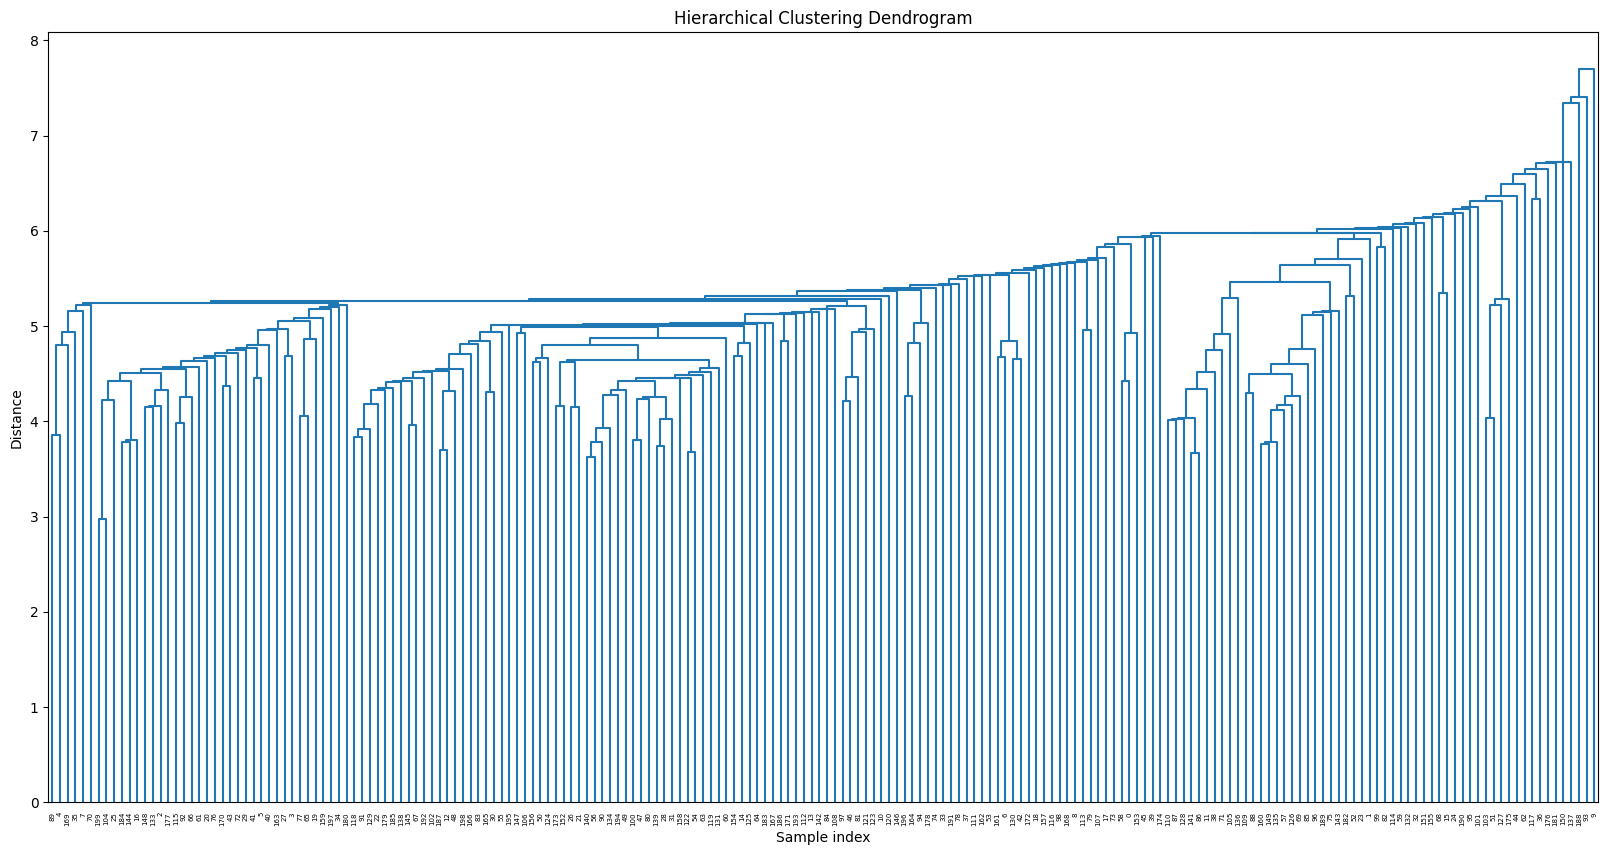

In [91]:
distance_matrix = 1 - similarity_matrix

linked = linkage(distance_matrix, 'single')

plt.figure(figsize=(20, 10))
dendrogram(linked, 
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

tensor([[0.7578, 0.9942, 0.9857,  ..., 0.9744, 0.9068, 0.9875],
        [0.9713, 0.7709, 0.9215,  ..., 1.0709, 0.9735, 0.8474],
        [0.9865, 1.0181, 0.7710,  ..., 0.9902, 1.0348, 0.9621],
        ...,
        [0.9702, 1.0025, 1.0127,  ..., 0.9112, 0.9133, 0.8244],
        [0.9659, 0.9890, 0.9770,  ..., 1.0010, 0.8030, 0.8307],
        [0.9732, 0.9707, 1.0650,  ..., 0.9808, 0.8552, 0.7675]])


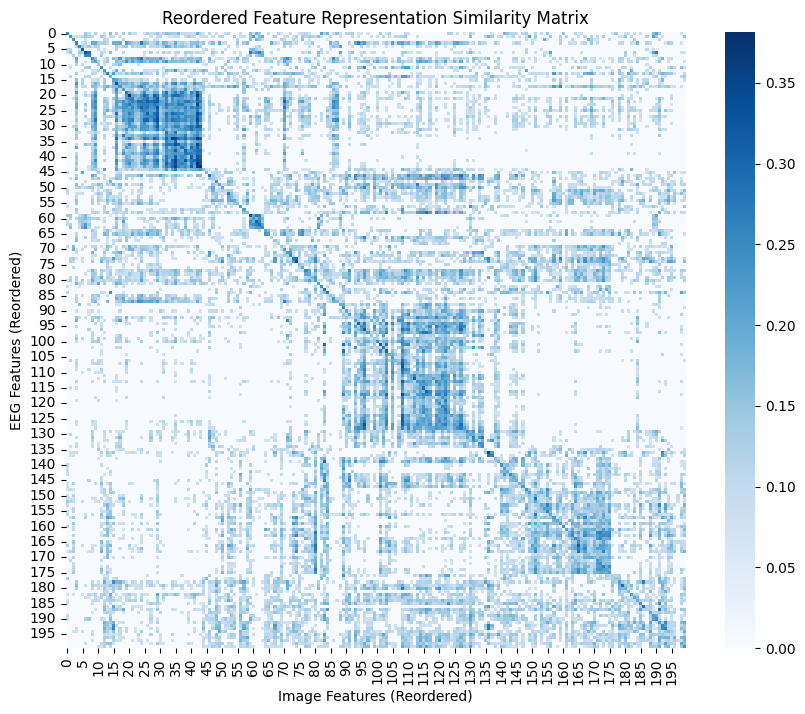

In [140]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns
import matplotlib.pyplot as plt



distance_matrix = 1 - similarity_matrix

linked = linkage(distance_matrix, 'single')

leaf_order = leaves_list(linked)

sorted_similarity_matrix = similarity_matrix[:, leaf_order][leaf_order, :]
distance_matrix = 1 - sorted_similarity_matrix
print(distance_matrix)
sorted_similarity_matrix[distance_matrix > 0.93] = 0
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_similarity_matrix, cmap='Blues')
plt.title('Reordered Feature Representation Similarity Matrix')
plt.xlabel('Image Features (Reordered)')
plt.ylabel('EEG Features (Reordered)')
plt.show()

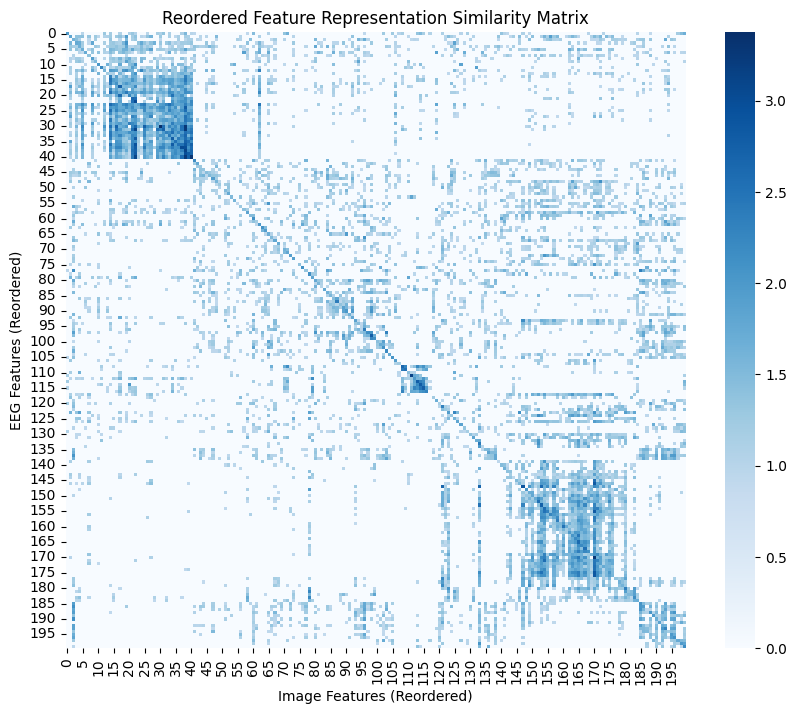

In [97]:

distance_matrix = 1 - similarity_matrix

similarity_matrix[distance_matrix > 0.99] = 0

linked = linkage(distance_matrix, 'single')

leaf_order = leaves_list(linked)

sorted_similarity_matrix = similarity_matrix[:, leaf_order][leaf_order, :]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_similarity_matrix, cmap='Blues')
plt.title('Reordered Feature Representation Similarity Matrix')
plt.xlabel('Image Features (Reordered)')
plt.ylabel('EEG Features (Reordered)')
plt.show()

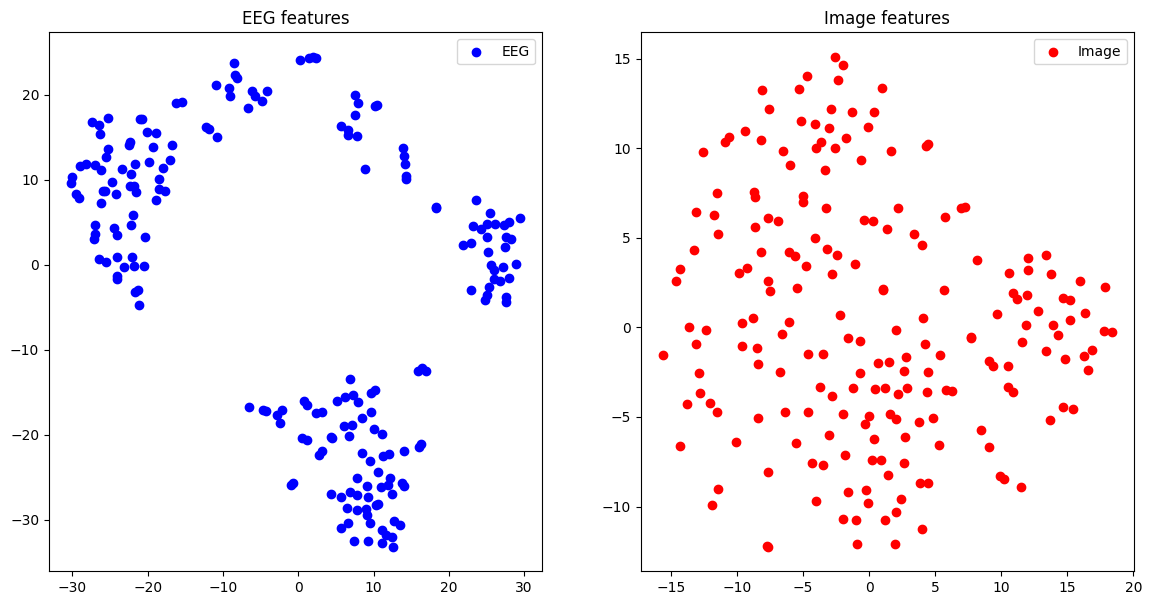

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


combined_features = np.vstack((eegfeatures, imgfeatures))

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(combined_features)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].scatter(tsne_results[:len(eegfeatures), 0], tsne_results[:len(eegfeatures), 1], c='blue', label='EEG')
axes[0].set_title('EEG features')
axes[0].legend()

axes[1].scatter(tsne_results[len(eegfeatures):, 0], tsne_results[len(eegfeatures):, 1], c='red', label='Image')
axes[1].set_title('Image features')
axes[1].legend()

plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42)
img_tsne = tsne.fit_transform(img_features)
eeg_tsne = tsne.fit_transform(eeg_features)

categories = ['animal', 'food', 'vehicle', 'tool']
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 'x']

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for category, color in zip(categories, colors):
    indices = (img_labels == category) & (is_train)
    axes[0].scatter(img_tsne[indices, 0], img_tsne[indices, 1], c=color, marker=markers[0], label=f"{category} (train)", alpha=0.5)
    indices = (img_labels == category) & (~is_train)
    axes[0].scatter(img_tsne[indices, 0], img_tsne[indices, 1], c=color, marker=markers[1], label=f"{category} (test)", alpha=0.5)
axes[0].set_title('Visual features')
axes[0].legend()

for category, color in zip(categories, colors):
    indices = (eeg_labels == category) & (is_train)
    axes[1].scatter(eeg_tsne[indices, 0], eeg_tsne[indices, 1], c=color, marker=markers[0], label=f"{category} (train)", alpha=0.5)
    indices = (eeg_labels == category) & (~is_train)
    axes[1].scatter(eeg_tsne[indices, 0], eeg_tsne[indices, 1], c=color, marker=markers[1], label=f"{category} (test)", alpha=0.5)
axes[1].set_title('EEG features')
axes[1].legend()

plt.tight_layout()
plt.show()